In [25]:
%%capture
pip install pytorch

In [26]:
%%capture
pip install tqdm

In [10]:
import torch
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
from torch import nn

In [49]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        n_categories=2
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [50]:
# %load ctrnn/datagen.py
import random
import numpy as np

khz = 1000

def random_size():
    return random.randint(5,10)

def random_times(freq):
    sample_rate = 5.1*khz
    period = 2*np.pi*1.0/freq
    times = np.arange(0, period, 1.0/sample_rate)
    return times

def random_phase():
    return np.pi*random.random()

def random_noise():
    return abs(0.3*random.random())

def random_freq(exclude):
    l,h = exclude
    while True:
        freq = 20.0*khz*random.random()
        if not (freq >= l and freq <= h):
            return freq

def sine(inputs,freq,ampl,phase):
    return ampl*np.sin(freq*np.array(inputs)+phase)

def random_wakeme():
    freq = 2.0*khz
    times = random_times(freq)
    noise = np.random.normal(0,random_noise(),len(times))
    signal = sine(times,2*khz,0.7,random_phase())
    data = signal+noise
    cat = Category.WAKEME
    return (data,cat)

def random_ignore():
    freq =random_freq([1.6*khz,44.1*khz])
    times = random_times(freq)
    noise = np.random.normal(0,random_noise(),len(times))
    signal = sine(times,freq,0.3,random_phase())
    data = signal+noise
    cat = Category.IGNORE
    return (data,cat)

def to_tensor(sig,cat):    
    cat_tensor = torch.zeros(1, 2)
    cat_tensor[0][cat.code()] = 1
    sig_tensor = torch.zeros(len(sig), 1, 1)
    targ_tensor = torch.zeros(len(sig), 1, 1)
    for li in range(len(sig)):
        sig_tensor[li][0][0] = sig[li]
        targ_tensor[li][0][0] = cat.code()
        
    return sig_tensor,cat_tensor,targ_tensor

def random_example():
    idx = random.randint(0,1)
    cat = Category.from_code(idx)
    if cat == Category.WAKEME:
        return random_wakeme()
    else:
        return random_ignore()


In [51]:
# %load ctrnn/category.py
class Category(Enum):
    WAKEME = "WAKEME"
    IGNORE = "IGNORE"
    def code(self):
        if self == Category.WAKEME:
            return 0
        else:
            return 1
        
    @staticmethod
    def from_code(code):
        mapping = {0:Category.WAKEME, 1:Category.IGNORE}
        return mapping[code]
    
    @staticmethod
    def series():
        return [Category.WAKEME, Category.IGNORE]



In [52]:
criterion = nn.NLLLoss()

In [53]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [54]:
import time
import math
import tqdm
n_iters = 100000
print_every = 5000
plot_every = 1000


rnn = RNN(1, 2, 1)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    sig,cat = random_example()
    T_sig,T_cat,T_targ = to_tensor(sig,cat)
    output, loss = train(T_cat,T_sig,T_targ)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

0


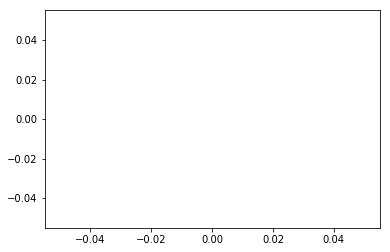

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
print(len(all_losses))
plt.figure()
plt.plot(all_losses)

In [39]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(signal_tensor):
    hidden = rnn.initHidden()

    for i in range(signal_tensor.size()[0]):
        output, hidden = rnn(signal_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    (signal,cat),(signal_tensor,cat_tensor) = random_example()
    output = evaluate(signal_tensor)
    guess, guess_i = OutputToCategory(output)
    category_i = cat.code()
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


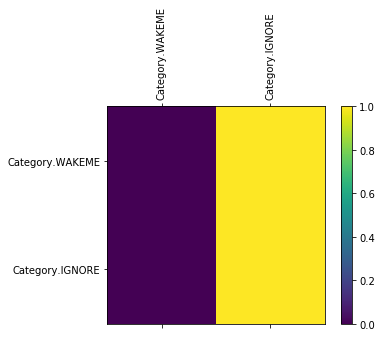

In [41]:

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + Category.series(), rotation=90)
ax.set_yticklabels([''] + Category.series())

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [40]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in criterion.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:


In [197]:

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in rnn.state_dict():
    print(param_tensor, "\t", rnn.state_dict()[param_tensor].size())
    print(rnn.state_dict()[param_tensor])

Model's state_dict:
i2h.weight 	 torch.Size([1, 2])
tensor([[1.1011, 1.2531]])
i2h.bias 	 torch.Size([1])
tensor([-0.9085])
i2o.weight 	 torch.Size([2, 2])
tensor([[ 0.8214,  1.1743],
        [-1.1798, -1.2255]])
i2o.bias 	 torch.Size([2])
tensor([-0.6843,  1.0526])
